## Configuration

In [2]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error

Importing plotly failed. Interactive plots will not work.


In [3]:
from src.widgets import get_config_widgets, select_features
from src.dataset import get_datasets, normalize_data
from src.feature import create_features, split
from src.prediction import linear_regression, predict_mse, predict_mae
from src.plot import plot_price_split, feature_importance, plot_predicted

In [4]:
price_interval, prediction_date_picker, eval_size, normalize =  get_config_widgets()

IntRangeSlider(value=(-74, 222), continuous_update=False, description='Energy Price Interval', max=900, min=-4…

DatePicker(value=datetime.date(2024, 10, 1), description='Prediction Date', step=1)

FloatSlider(value=0.05, description='Evaluation Set Size', max=0.2, step=0.01)

Checkbox(value=False, description='Normalize')

## Data loading

In [5]:
merged_df, e_price_df = get_datasets()

## Feature Selection

In [6]:
get_features, default_features = select_features()

Output()

Button(description='Confirm Selection', style=ButtonStyle())

In [7]:
# RERUN WHEN TICKING the NORMALIZED BOX 

selected_features = get_features()
FEATURES = default_features if not selected_features else selected_features

min_price, max_price = price_interval.value

features_df = create_features(merged_df)

features_interval_df = features_df.copy()[
    (features_df["Price"] >= min_price) &
    (features_df["Price"] <= max_price)
]

normalized_features_df, normalized_e_price_df, normalized_interval_df, e_price_scaler = normalize_data(features_df.copy(), e_price_df.copy(), features_interval_df.copy())

TARGET = merged_df["Price"]
TARGET_INTERVAL = features_interval_df["Price"]
TARGET_NORMALIZED = normalized_features_df["Price"]
TARGET_NORMALIZED_INTERVAL = normalized_interval_df["Price"]

combined_df = pd.concat([features_df[FEATURES], TARGET], axis=1)
combined_interval_df = pd.concat([features_interval_df[FEATURES], TARGET_INTERVAL], axis=1)
combined_normalized_df = pd.concat([normalized_features_df[FEATURES], TARGET_NORMALIZED], axis=1)
combined_normalized_interval_df = pd.concat([normalized_interval_df[FEATURES], TARGET_NORMALIZED_INTERVAL], axis=1)


if normalize.value:
    train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST = split(combined_normalized_df,eval_size.value, prediction_date_picker.value)
    train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL = split(combined_normalized_interval_df,eval_size.value, prediction_date_picker.value)
    scalar = e_price_scaler
    
else:
    train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST = split(combined_df,eval_size.value, prediction_date_picker.value)
    train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL = split(combined_interval_df,eval_size.value, prediction_date_picker.value)
    scalar = None

TARGET = "Price"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_val = eval[FEATURES]
y_val = eval[TARGET]

X_train_XGB = train_XGB[FEATURES]
y_train_XGB = train_XGB[TARGET]

X_test_XGB = test_XGB[FEATURES]
y_test_XGB = test_XGB[TARGET]

X_val_XGB = eval_XGB[FEATURES]
y_val_XGB = eval_XGB[TARGET]



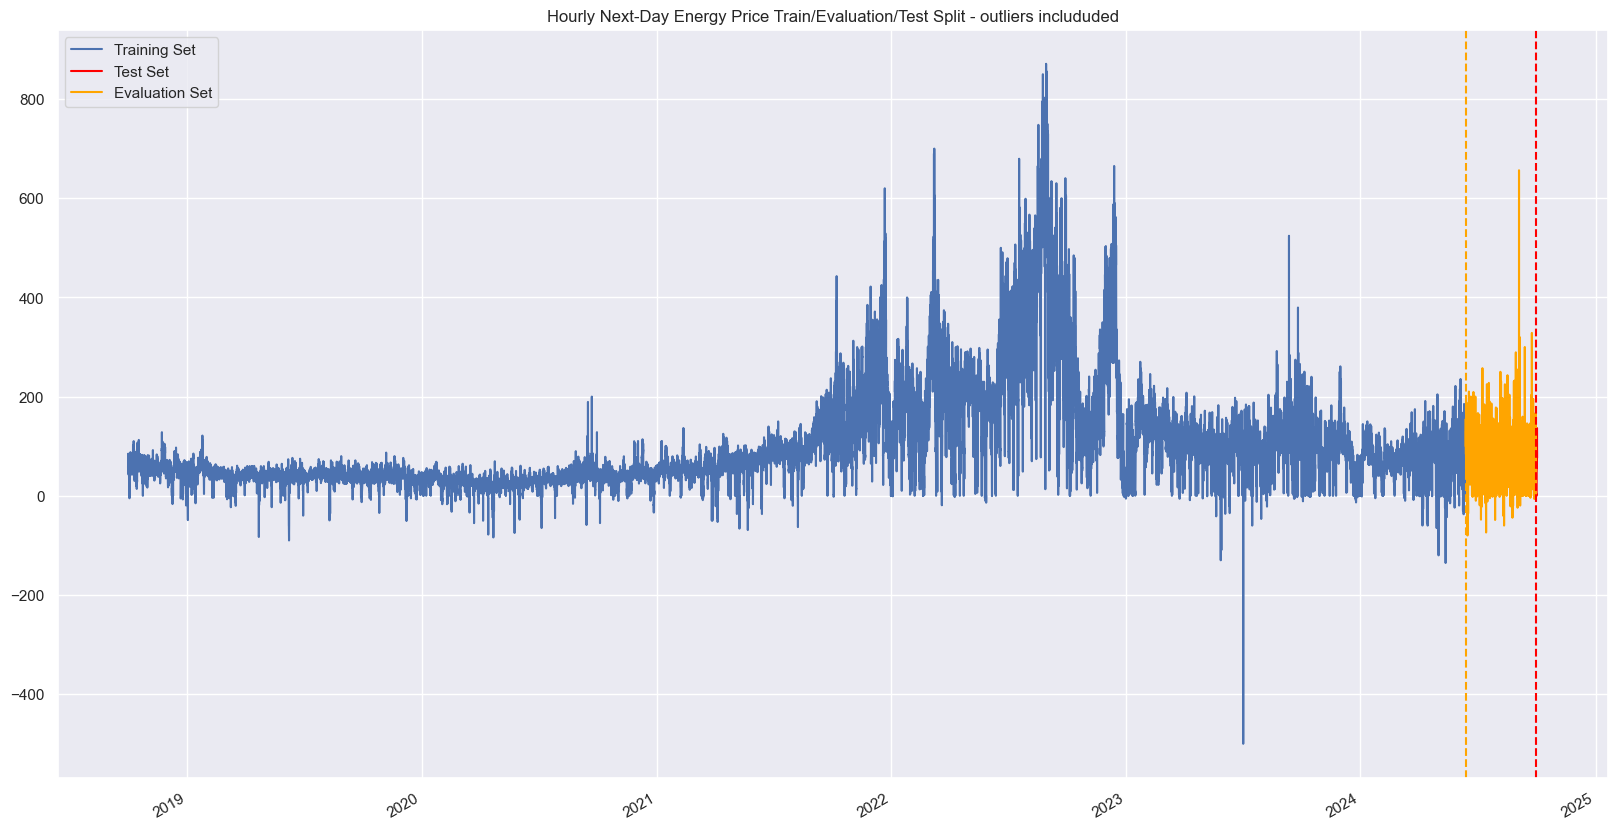

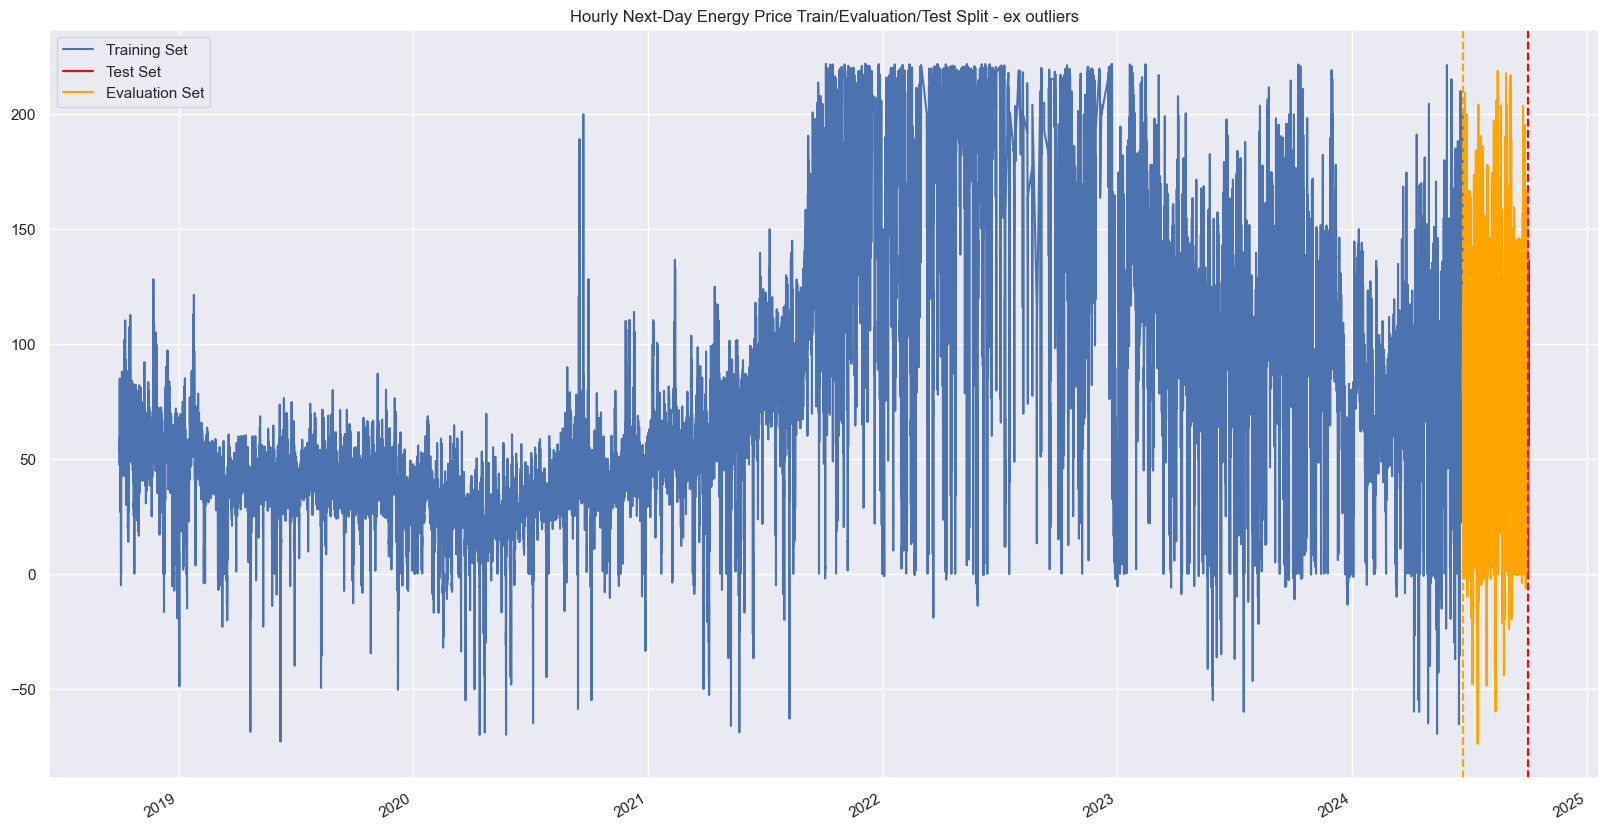

In [8]:
plot_price_split(train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST, "outliers includuded")
plot_price_split(train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL, "ex outliers")

## Prediction

### Linear Regression

In [9]:
lr_predictions, lr_yt = linear_regression(X_train, y_train, X_test, y_test, scalar)
lr_predictions_interval, lr_yt_interval = linear_regression(X_train_XGB, y_train_XGB, X_test_XGB, y_test_XGB, scalar)

### XGBoost

In [10]:
best_params = {
    "base_score": 0.380924762889507,
    "early_stopping_rounds": 215,
    "max_depth": 80,
    "learning_rate": 0.06,
    "n_estimators": 150,
    "gamma": 0.9,
    "min_child_weight": 6,
    "subsample": 0.5719023844219375,
    "colsample_bytree": 0.8815691043681952,
}
xgb_y_predicted_mse, xgb_mse = predict_mse(best_params, X_train, y_train, X_val, y_val, X_test)
xgb_y_predicted_mae, xgb_mae = predict_mae(best_params, X_train, y_train, X_val, y_val, X_test)

[0]	validation_0-rmse:85.33462
[25]	validation_0-rmse:22.83879
[50]	validation_0-rmse:12.82933
[75]	validation_0-rmse:11.72242
[100]	validation_0-rmse:11.51259
[125]	validation_0-rmse:11.45623
[149]	validation_0-rmse:11.40188
[0]	validation_0-mae:72.88116
[25]	validation_0-mae:16.88167
[50]	validation_0-mae:7.35458
[75]	validation_0-mae:6.37210
[100]	validation_0-mae:6.26409
[125]	validation_0-mae:6.26033
[149]	validation_0-mae:6.26366


### Prophet

In [11]:
model = Prophet()

# Add time-based regressors
for feature in FEATURES:
     model.add_regressor(feature)
     
train_data = train.rename(columns={"Price": "y"}).reset_index().rename(columns={"index": "ds"}).dropna()
eval_data = eval.rename(columns={"Price": "y"}).reset_index().rename(columns={"index": "ds"}).dropna()
test_data = test.rename(columns={"Price": "y"}).reset_index().rename(columns={"index": "ds"}).dropna()


model.fit(train_data)

prophet_predictions = model.predict(test_data)["yhat"]
prophet_test_data = test_data.rename(columns={"ds": "index", "y": "Price"}).set_index("index")



22:16:42 - cmdstanpy - INFO - Chain [1] start processing
22:16:50 - cmdstanpy - INFO - Chain [1] done processing


## Results

### Linear Regression

KeyError: 'Price'

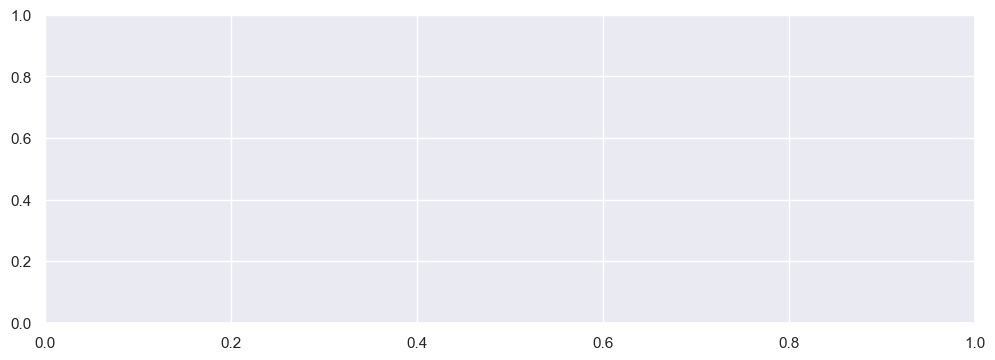

In [13]:
plot_predicted(lr_yt, lr_predictions, "MSE")
plot_predicted(lr_yt_interval, lr_predictions_interval, "MSE")

### XGBoost

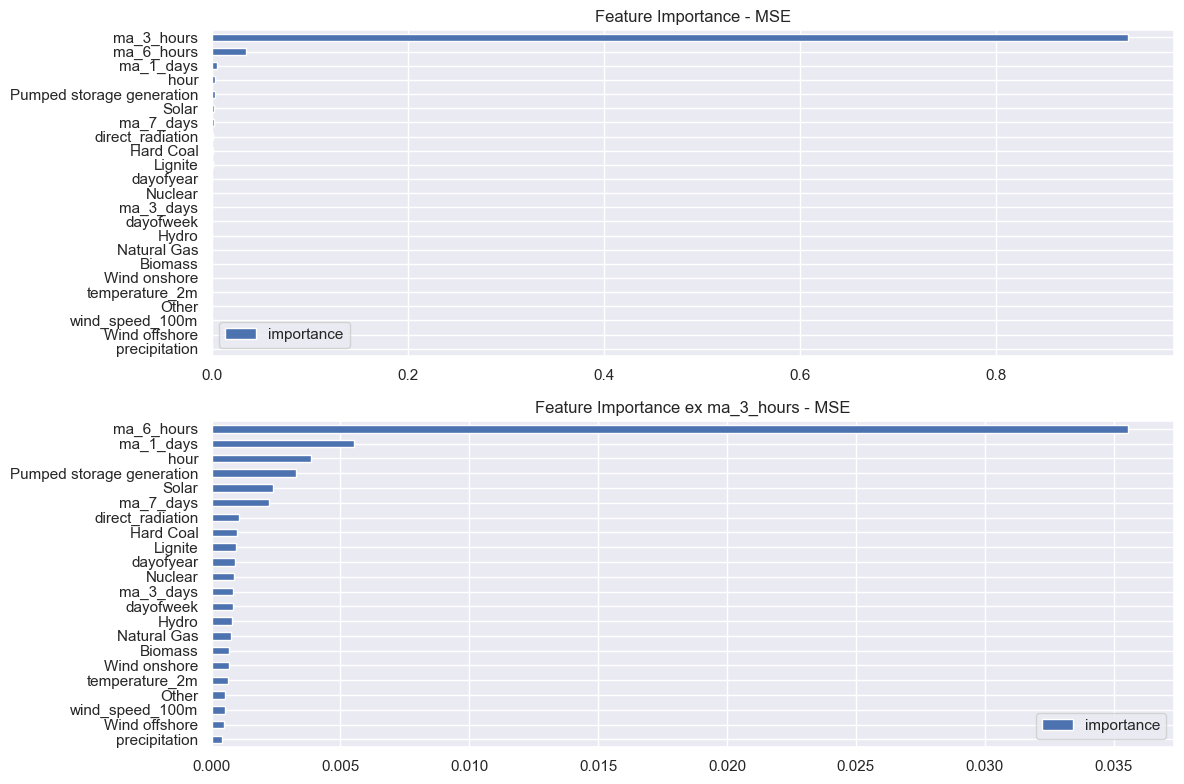

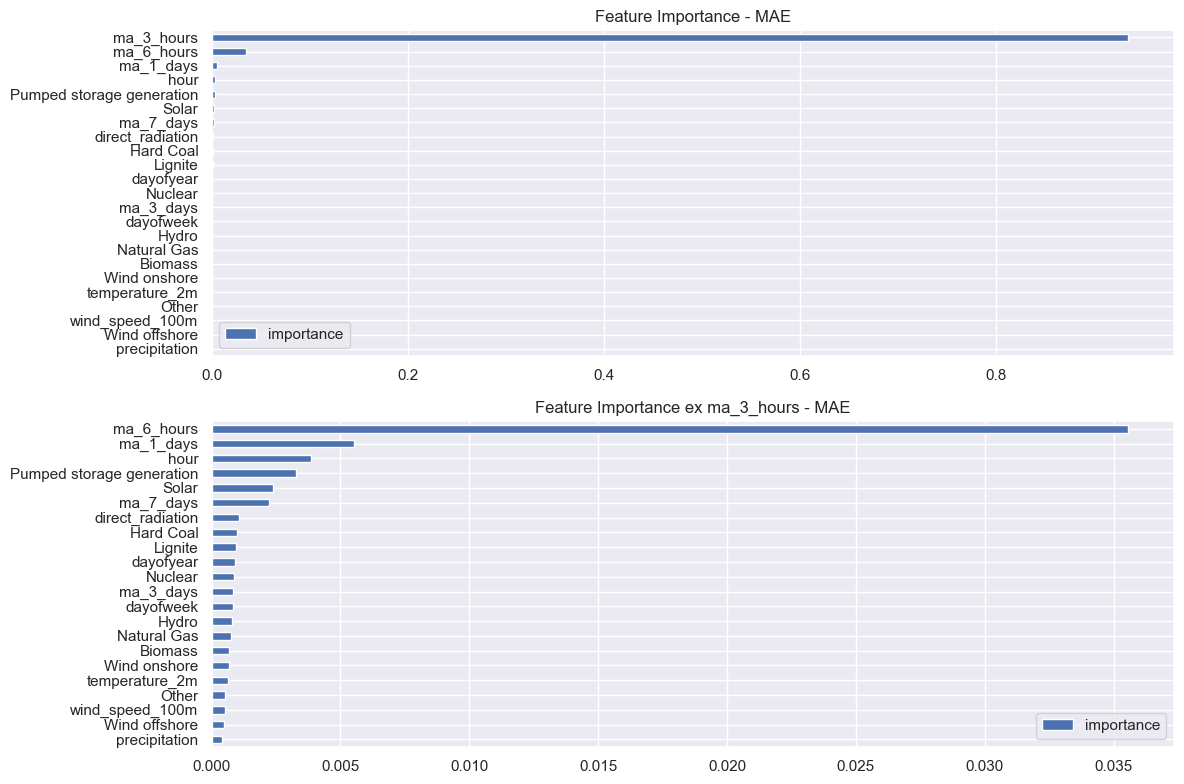

In [ ]:
feature_importance(xgb_mse, "MSE")
feature_importance(xgb_mae, "MAE")

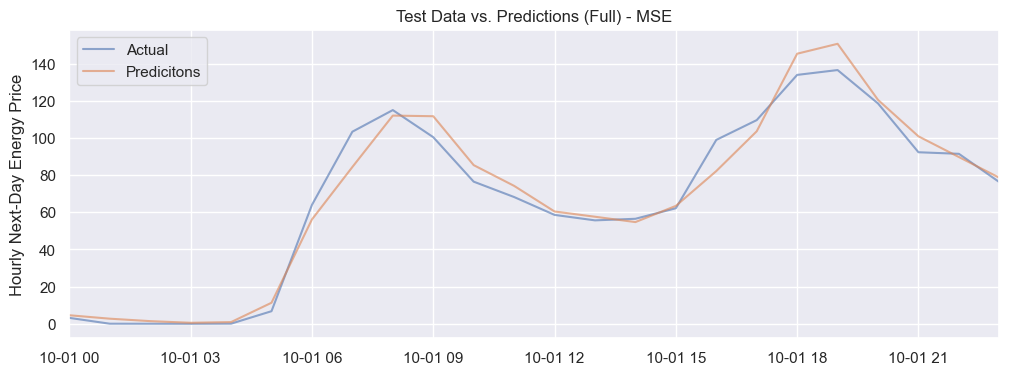

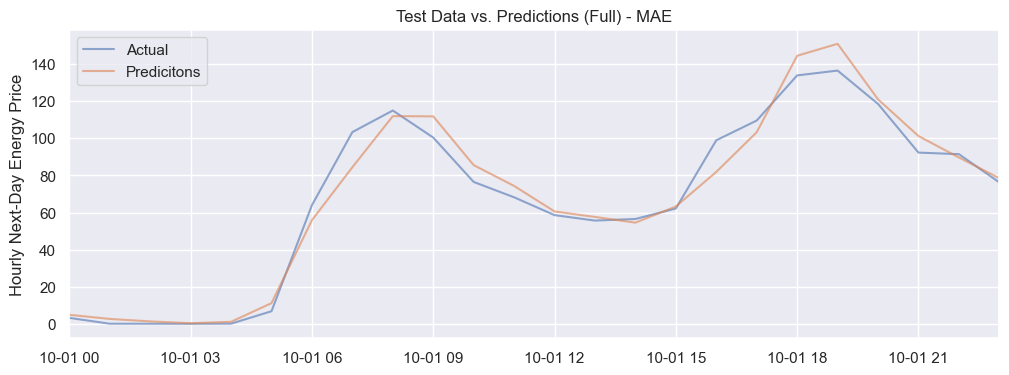

In [26]:
for predictions, objective_name in [(xgb_y_predicted_mse, "MSE"), (xgb_y_predicted_mae, "MAE")]:
    plot_predicted(test, predictions, objective_name)

### Prophet

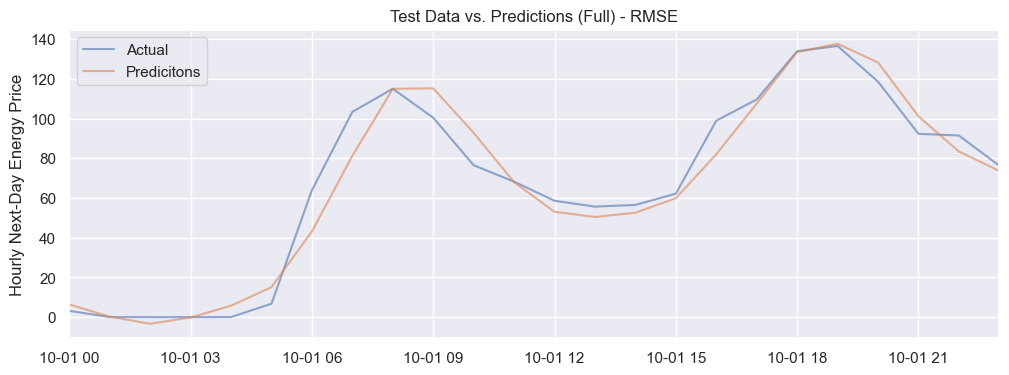

In [27]:
plot_predicted(prophet_test_data, prophet_predictions, "RMSE")